# Feature Selection and Feature Engineering

* Add a description of the dataset - what are gravitational waves? What is our data and features? What kind of correlations we expect. 
* Create class of waveform, add FT and show an example plot with PSD. 

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import time, glob, os, math
from matplotlib import cm 

import matplotlib as mpl
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)
mpl.rc('axes', labelsize=16, grid=True)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)

from sklearn.decomposition import PCA, FastICA, KernelPCA, FactorAnalysis
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.random_projection import GaussianRandomProjection
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture as GM
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier as DT

In [2]:
#Fix the random seed
random_seed = 42

In [3]:
def read_paramvalue(metafile, parameter):
    '''Return the parameter value from data
    
    Parameters:
    metafile (str) - Metadata filepath
    parameter (str) - parameter name
    '''
   
    assert(os.path.exists(metafile)),"Path to metadata file does not exist"
    
    datafile = file(metafile)
    datafile.seek(0)
    for line in datafile:
        if parameter in line:
            break
    
    line = line.split(',')
    
    #rstrip - remove any trailing charaters
    data_value = line[-1].rstrip()
    datafile.close()
    return data_value


def plot(x, y, xlabel, ylabel):     #Create a plot
    '''Generate a line plot of y vx x
    
    Parameters - 
    x,y - numpy arrays
    xlabel, ylabel - strings
    '''
    plt.figure(figsize=(12,6))
    plt.plot(x,y,color='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    plt.close()
    
    
def scatter(ax, x, y, clr, xlabel, ylabel, title):     #Create a scatter plot
    '''Generate a scatter plot 
       ax - subplot
       x, y - numpy arrays
       xlabel, ylabel title - strings  
    '''
    clr_label = {0:'orange', 1:'forestgreen', 2:'deepskyblue',3:'gold', 4:'b', 5:'k', 6:'red', 7:'darkmagenta' }
    names = {'NonSpinning':0,'AlignedSpins':1,'Precessing':2}
    target_names = np.vectorize(names.get)(clr)
    target_labels =  np.vectorize(clr_label.get)(target_names)
   
    ax.scatter(x,y,facecolors=target_labels, edgecolors=None) 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax


In [ ]:
#Principal Component Analysis 
def func_PCA(n_comp, data):
    
    data_copy = np.copy(data)
    num_samples, num_features = np.shape(data_copy)
    time_init = time.time()
    
    #Select PCA methods and number of components
    clf = PCA(svd_solver='full', n_components=n_comp, random_state=random_seed)   
    
    #Apply PCA
    transformed_data = clf.fit_transform(data_copy)
    
    #Compute variance and score (avg log likelihood)
    var = clf.explained_variance_
    score = clf.score(data_copy)
    time_pca = time.time() - time_init
    
    #print("Projected {} samples from {} to {} with score {}" .format(num_samples, num_features, n_comp, score))
    return transformed_data, time_pca


#Independent Component Analysis
def func_ICA(n_comp, data):
    
    data_train = np.copy(data)
    num_samples, num_features = np.shape(data)[:]
    time_init = time.time()
    
    #Choose the ICA methods and apply ICA
    clf = FastICA(n_components=n_comp, random_state=random_seed)   
    transformed_data = clf.fit_transform(data_train)
    time_ica = time.time() - time_init
    #print("Projected %d samples from %d to %d" % (num_samples, num_features, n_comp))
    
    return transformed_data, time_ica

#Randomized component analysis
def func_RCA(n_comp, data, randst=random_seed):
    
    data_train = np.copy(data)
    num_samples, num_features = np.shape(data)[:]
    eps_range = np.linspace(0.1,0.99,8)
    time_init = time.time()
    
    # Choose RCA method and apply RCA
    clf = SRP(n_components=n_comp, eps=eps_range.tolist(),random_state=randst) 
    transformed_data = clf.fit_transform(data_train)
    time_rca = time.time()-time_init
    #print("Projected %d samples from %d to %d" % (num_samples, num_features, n_comp))
    
    return transformed_data,time_rca



# Analysis of PCA results
def PCA_Analysis(data,y):
    num_samples, num_features = np.shape(data)[:]  
    num_comp = np.arange(1, 20, 5)

    clf = PCA(svd_solver='full',random_state=rs)
    scores, pct_var,var = [], [], []
    data_copy = np.copy(data)
    
    # PCA with Cross Validation
    for n in num_comp:
        clf.n_components = n
        transformed_data_cv = clf.fit_transform(data_copy)
        scores.append(np.mean(cross_val_score(clf, data_copy, cv=3)))
        #scores.append(clf.score(data_copy,y))
        pct_var.append(clf.explained_variance_ratio_[1:] )
        var.append(clf.explained_variance_[1:])
        
    #print("Number of PCA components - {} and PCA score - {}\n".format(clf.n_components_, clf.score(data_train)))  #score returns average log likelihood over all k validations
    #best_numcomp_cv = num_comp[np.argmax(scores)] 
   
    #print("Best number of components by PCA CV = {} and  score = {} ".format(best_numcomp_cv, np.amax(scores)))
     
    plt.clf()
    fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(12,5))
    ax1.plot(num_comp, scores, 'b')
    ax1.set_xlabel('Number of PCA Components')
    ax1.set_ylabel('Score')
    ax2.plot(range(num_comp[-1]), pct_var[-1], 'r')
    ax2.set_xlabel( "Number of PCA Components")
    ax2.set_ylabel("Percent Variance")
    ax2.set_xlim(0,20)
    ax3.plot(range(num_comp[-1]), var[-1], 'r')
    ax3.set_xlabel( "Number of PCA Components")
    ax3.set_ylabel("Explained Variance")
    

    plt.tight_layout()
    plt.show()
    plt.close()
    

    

In [6]:
os.chdir('/localdata2/bkhamesra3/MachineLearning/GW-MLClassification/Data/')

(486, 1551)


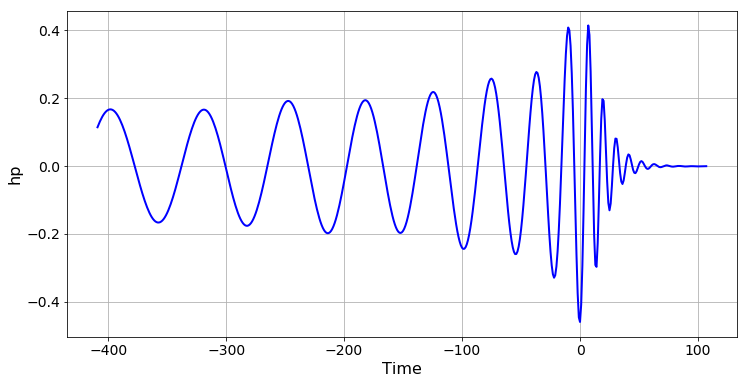

In [9]:
#Loading the Dataset

data, wf_tag, metadata = [], [],[]
GT_filepaths = sorted(glob.glob("FilteredData/GT*.txt"))
SXS_filepaths = sorted(glob.glob("FilteredData/SXS*.txt"))


for f in GT_filepaths:
    dataset = np.loadtxt(f)
    
    dataset = np.concatenate(dataset.T)
    data.append(dataset)
    wf_tag.append(os.path.basename(f).split(".")[0])
    
    metafile = os.path.join("Metadata", "Metadata_"+wf_tag[-1]+".csv")
    metadata.append(read_paramvalue(metafile, 'spin-type'))
    
    
for f in SXS_filepaths:
    dataset = np.loadtxt(f)
    dataset = np.concatenate(dataset)
    data.append(dataset)
    wf_tag.append(os.path.basename(f).split(".")[0])
    
    metafile = os.path.join("Metadata", "Metadata_"+wf_tag[-1]+".csv")
    metadata.append(read_paramvalue(metafile, 'spin-type'))
    
data = np.matrix(data)
y = np.array(metadata)
print np.shape(data)
          
#Check
n = np.shape(data)[1]/3
t = data[0,:n].T
hp =  data[0,n:2*n ].T

plot(t, hp, "Time", "hp")





In [10]:
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=0.85, random_state=12)
#data_train, y_train = shuffle(data_train, y_train, random_state=random_seed)

#Standardize each feature of X and Y to have mean 0 and variance 1
SS_data =StandardScaler()
SS_y = StandardScaler()

data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#y_train = SS_y.fit_transform(y_train)
#y_test = SS_y.transform(y_test)


/localdata/bkhamesra3/softwares/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Eigenvalues (Variance) of first ten components is [862.59431734 123.54280463 104.16236658  63.7084611   60.31905534
  44.88623225  40.10274659  36.96972027  28.05263029  23.56139011] 



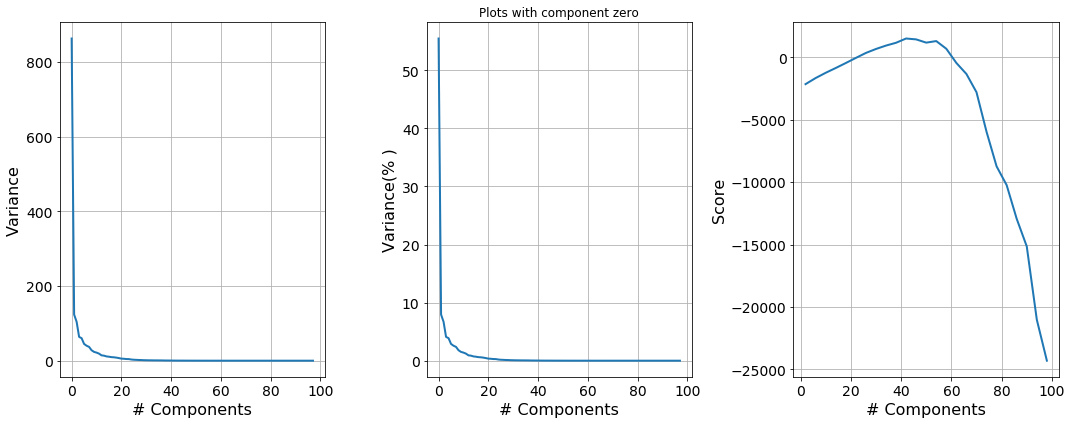

In [11]:
#PCA_Analysis(data_train,y_train)
clf = PCA(svd_solver='full')
scores, pct_var,var = [], [], []
data_copy = np.copy(data_train)
numcomp = np.arange(2,100,4)
for n in numcomp:
    clf.n_components = n
    transformed_data = clf.fit_transform(data_copy)
    scores.append(np.mean(cross_val_score(clf, data_copy, cv=3)))
    #scores.append(clf.score(data_copy,y))
    pct_var = 100.*clf.explained_variance_ratio_
    var = clf.explained_variance_

#print pct_var[0:25]
print("Eigenvalues (Variance) of first ten components is {} \n".format( var[0:10]))
plt.clf
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
ax1.plot(range(0, n), var[0:])
ax1.set_xlabel('# Components')
ax1.set_ylabel('Variance')

ax2.plot(range(0,n), pct_var[0:])
ax2.set_xlabel('# Components')
ax2.set_ylabel('Variance(% )')
ax2.set_title("Plots with component zero")

ax3.plot(numcomp, scores)
ax3.set_xlabel('# Components')
ax3.set_ylabel('Score')
plt.tight_layout()
plt.show()
#plt.savefig("Figures/PCA_AllbutFirstComp.png")
plt.close()




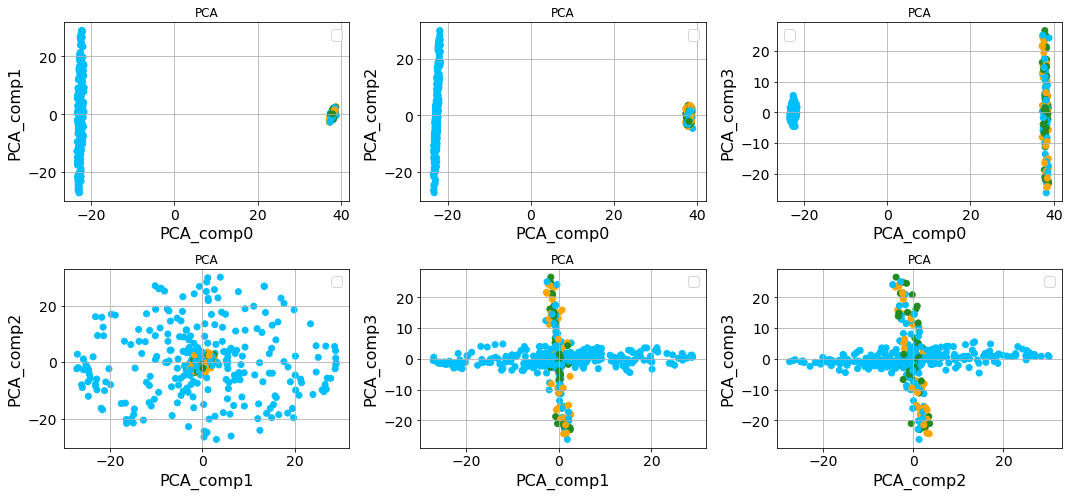

In [12]:
#PCA Continued

plt.clf
clf = PCA(svd_solver='full')
data_copy = np.copy(data_train)
clf.n_components = 40
transformed_data = clf.fit_transform(data_copy)

fig, axes = plt.subplots(2,3, figsize=(15,7))
axes = axes.ravel()
k=0

for i in range(0,4):
        for j in  range(i+1,4):
                
                axes[k] =  scatter(axes[k], transformed_data[:,i], transformed_data[:,j],y_train,"PCA_comp%d"%i, "PCA_comp%d"%j, "PCA")
                k = k+1
plt.tight_layout()               
plt.show()


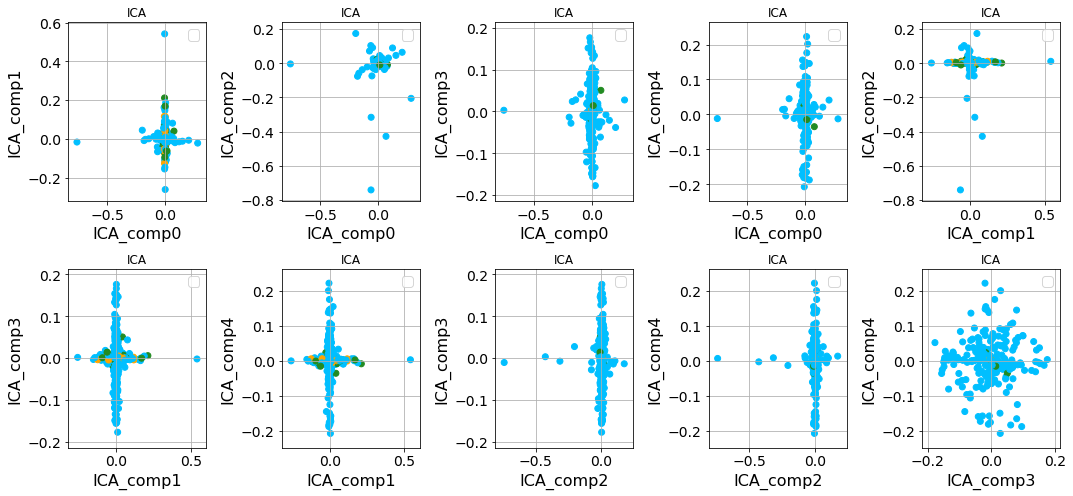

In [13]:
#ICA - Not very helpful

plt.clf
clf = FastICA(random_state= 12)
data_copy = np.copy(data_train)
clf.n_components = 40
transformed_data = clf.fit_transform(data_copy)

fig, axes = plt.subplots(2,5, figsize=(15,7))
axes = axes.ravel()
k=0

for i in range(0,5):
        for j in  range(i+1,5):
                
                axes[k] =  scatter(axes[k], transformed_data[:,i], transformed_data[:,j],y_train,"ICA_comp%d"%i, "ICA_comp%d"%j, "ICA")
                k = k+1
plt.tight_layout()               
plt.show()


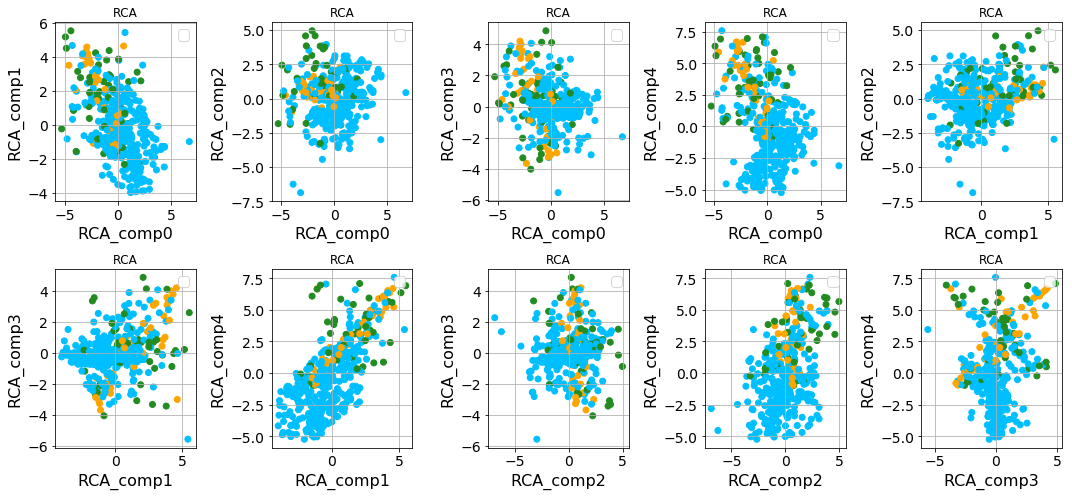

In [15]:
#RCA - worst case

plt.clf
num_samples, num_features = np.shape(data)[:]

clf = GaussianRandomProjection( eps=0.5)     #eps_range.tolist(),random_state=10) 
#clf.n_components = 40

data_copy = np.copy(data_train)
transformed_data = clf.fit(data_copy, y_train)
transformed_data = clf.transform(data_copy)
#print("Number of selected random projections = %d"%clf.n_component_)

fig, axes = plt.subplots(2,5, figsize=(15,7))
axes = axes.ravel()
k=0

for i in range(0,5):
    for j in  range(i+1,5):       
        axes[k] =  scatter(axes[k], transformed_data[:,i], transformed_data[:,j],y_train,\
                           "RCA_comp%d"%i, "RCA_comp%d"%j, "RCA")
        k = k+1
plt.tight_layout()               
plt.show()
